# Computer Vision Coursework Submission (IN3060/INM460)

**Student name, ID and cohort:** Elnara Mammadova (210026788) - PG

# CNN Facial Emotion Recognition

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path_to_folder = 'CW_Folder_PG' 
dir_path = os.path.join('drive', 'My Drive', path_to_folder)

## Dependencies

In [4]:
!pip install skorch

     |████████████████████████████████| 155 kB 7.0 MB/s 


## Import Libraries

In [5]:
import os
import random
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
import imageio
import cv2

# libraries necessary for neural network model
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset

# libraries necessary for sklearn skorch skorch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from skorch.callbacks import Checkpoint,  LRScheduler, EpochScoring, EarlyStopping
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

%matplotlib inline

### Device

In [6]:
# If we have a GPU available, we'll set our device to GPU. 
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Seed everything

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

## Load Dataset

In [8]:
# === Code adapted from Lab_07 of INM460 Computer Vision Module === ##

# Identify path to zipped dataset
zip_path = os.path.join(dir_path, 'CW_Dataset', 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [9]:
def import_data(label_name):
    """Load images and labels for train and test set from selected directories"""
    images = []
    labels = []
    
    img_files = [img for img in sorted(os.listdir(label_name)) if img.endswith('.jpg')] # image files sorted in ascending order
    label_file = os.path.join('labels', 'list_label_'+label_name+'.txt') # label file corresponding to train or test folders
    for img in img_files:
      images.append(io.imread(os.path.join(label_name, img)))
    df = pd.read_csv(label_file, header=None, delimiter=r"\s+")
    df = df.sort_values(0) # sort (in ascending order) label dataframe by first column which are img names
    labels = df.iloc[:, 1].tolist()
    return np.array(images), np.array(labels)

In [10]:
X_train, y_train = import_data('train')
X_test, y_test = import_data('test')

In [11]:
y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test) 

In [12]:
print(f'Train Labels: {y_train_counter}, \nTest Labels: {y_test_counter}')

Train Labels: Counter({4: 4772, 7: 2524, 5: 1982, 1: 1290, 3: 717, 6: 705, 2: 281}), 
Test Labels: Counter({4: 1185, 7: 680, 5: 478, 1: 329, 6: 162, 3: 160, 2: 74})


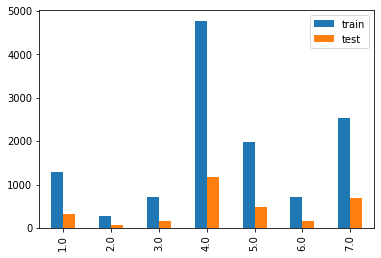

In [13]:
df = pd.DataFrame({'train': pd.Series(y_train_counter),
                   'test': pd.Series(y_test_counter) })

ax = df.plot.bar()
labs = [round(float(t.get_text()), 1) for t in ax.axes.get_xmajorticklabels()]
ax.set_xticklabels(labs);

### Random Oversampling

Random oversampling returned lower accuracies vs. SMOTE. Therefore SMOTE will be applied. 

In [14]:
# # example of random oversampling to balance the class distribution
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import RandomOverSampler 


# # strategy = {1: 3817, 2: 3817, 3: 3817, 4: 3817, 5: 3817, 6: 3817, 7: 3817}
# strategy = {1: 4772, 2: 4772, 3: 4772, 4: 4772, 5: 4772, 6: 4772, 7: 4772}
# oversample = RandomOverSampler(sampling_strategy=strategy)

# # flatten the image to be able to pass to sklearn
# num_rows=len(X_train)
# X_train_reshaped = np.array(X_train).reshape(num_rows,-1)
# X_train_, y_train = oversample.fit_resample(X_train_reshaped, y_train)
# X_train = X_train_.reshape(-1,100,100,3)

# print(Counter(y_train))

### Apply SMOTE 
Since we have clear imbalance problems we will apply oversampling technique to balance training set using SMOTE. Even though SMOTE returns distorded images, it still gives much better results than random oversampling. 

In [15]:
sm = SMOTE(random_state=42)
num_rows=len(X_train)
# flatten the image to be able to pass to sklearn
X_train_reshaped = np.array(X_train).reshape(num_rows,-1)
print(f'Flattened X_train shape: {X_train_reshaped.shape}, y_train shape: {np.shape(y_train)}')

Flattened X_train shape: (12271, 30000), y_train shape: (12271,)


In [16]:
# apply smote on flattened image
X_train_sm, y_train = sm.fit_resample(X_train_reshaped, y_train)
print(f'Smoted X_train shape: {X_train_sm.shape}, y_train shape: {np.shape(y_train)}')

Smoted X_train shape: (33404, 30000), y_train shape: (33404,)


In [17]:
# reshape the flattened image back to its [num_samples, height, width, channel] dimensions
# not we loose image quality here, however, we get better accuracies with SMOTE than without it nevertheless
X_train = X_train_sm.reshape(-1,100,100,3)
print(f'New X_train shape: {X_train.shape}, y_train shape: {np.shape(y_train)}')

New X_train shape: (33404, 100, 100, 3), y_train shape: (33404,)


In [18]:
del X_train_reshaped, X_train_sm # to preserve ram memory

### Split Dataset Train | Val | Test

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify = y_train, random_state=42)

In [20]:
print(f'X_train shape: {np.shape(X_train)} \nX_val shape: {np.shape(X_val)}, \nX_test shape: {np.shape(X_test)}')

X_train shape: (26723, 100, 100, 3) 
X_val shape: (6681, 100, 100, 3), 
X_test shape: (3068, 100, 100, 3)


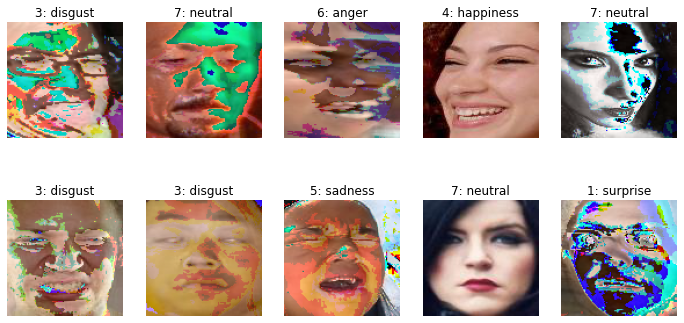

In [21]:
# === Code adapted from Lab_06 of INM460 Computer Vision Module === ##
# return 10 different random image every time
classes = {1: 'surprise', 2: 'fear', 3: 'disgust', 4: 'happiness', 5: 'sadness', 6: 'anger', 7: 'neutral'}
X_train_img = np.array(X_train)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
  for x in random.sample(range(len(X_train)), 10): 
      ax[i].imshow(X_train_img[x, :, :], cmap='gray')
      ax[i].set_title(f'{y_train[x]}: {classes[y_train[x]]}')
      ax[i].set_axis_off()
fig.tight_layout
plt.show()

### EDA

In [22]:
y_train_counter = Counter(y_train)
y_val_counter = Counter(y_val) 
y_test_counter = Counter(y_test) 

In [23]:
print(f'New y_train shape: {y_train.shape}, New y_val shape: {y_val.shape}, y_test shape: {y_test.shape}')

New y_train shape: (26723,), New y_val shape: (6681,), y_test shape: (3068,)


In [24]:
print(f'New Train Labels: {y_train_counter}, \nNew Val Labels: {y_val_counter}, \nTest Labels: {y_test_counter}')

New Train Labels: Counter({2: 3818, 1: 3818, 6: 3818, 3: 3818, 5: 3817, 7: 3817, 4: 3817}), 
New Val Labels: Counter({7: 955, 5: 955, 4: 955, 2: 954, 6: 954, 1: 954, 3: 954}), 
Test Labels: Counter({4: 1185, 7: 680, 5: 478, 1: 329, 6: 162, 3: 160, 2: 74})


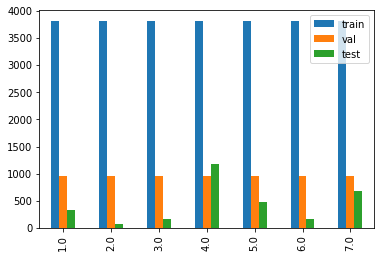

In [25]:
df = pd.DataFrame({'train': pd.Series(y_train_counter), 
                   'val': pd.Series(y_val_counter),
                   'test': pd.Series(y_test_counter) })

ax = df.plot.bar()
labs = [round(float(t.get_text()), 1) for t in ax.axes.get_xmajorticklabels()]
ax.set_xticklabels(labs);

### Organizing images per their corresponding label folders

In [26]:
!rm -rf ./train_new ./test_new ./val_new # run this cell if this folder exist in the directory already 

In [27]:
class_names = list(np.unique(y_train))

for i in class_names:
    os.makedirs(os.path.join('train_new',str(i)))
    os.makedirs(os.path.join('test_new',str(i)))
    os.makedirs(os.path.join('val_new',str(i)))

In [28]:
# Train data
for i in range(len(X_train)):
  img_idx = (str(i+1).zfill(5))
  img_file_name = "train_"+img_idx+".jpg"
  label_folder = str(y_train[i])
  path = os.path.join('train_new', label_folder, img_file_name)
  imageio.imwrite(path, X_train[i])
  # print(path) 

In [29]:
# Validation data
X_val = np.array(X_val)
for i in range(len(X_val)):
  img_idx = (str(i).zfill(5))
  img_file_name = "val_"+img_idx+".jpg"
  label_file = str(y_val[i])
  path = os.path.join('val_new', label_file, img_file_name)
  imageio.imwrite(path, X_val[i])
  # print(path)

In [30]:
# Test data
X_test = np.array(X_test)
for i in range(len(X_test)):
  img_idx = (str(i).zfill(5))
  img_file_name = "test_"+img_idx+".jpg"
  label_file = str(y_test[i])
  path = os.path.join('test_new', label_file, img_file_name)
  imageio.imwrite(path, X_test[i])
  # print(path)

In [31]:
!rm -rf ./new_data # run this cell if new_data folder exsists already

In [32]:
os.makedirs('new_data')
!mv "/content/train_new/" "/content/new_data/"
!mv "/content/val_new/" "/content/new_data/"
!mv "/content/test_new/" "/content/new_data/"

In [33]:
os.rename("/content/new_data/train_new", "/content/new_data/train") 
os.rename("/content/new_data/val_new", "/content/new_data/val")
os.rename("/content/new_data/test_new", "/content/new_data/test")

In [34]:
!cp -rf /content/new_data/ /content/drive/MyDrive/CW_Folder_PG/CW_Dataset/

^C


## CNN

### Data preparation

Transform data to tensors and apply normalization to the image in the range of [-1, 1], with std = 0.5, and mean = 0.5. Normalization helps CNN to perform better, by getting data within a range and reduce the skewnewss which helps it learn faster and better. 

In [35]:
# === Code adapted from Lab_08 of INM460 Computer Vision Module === ##

transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Grayscale(1), # better accuracies with rgb
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_dir = 'new_data'

train_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_dir, 'train'),
        transform=transform
    )
val_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_dir, 'val'),
        transform=transform
    )
test_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'),
        transform=transform
    )

In [36]:
for i, (images, labels) in enumerate(train_dataset):
    print(images.shape)
    print(images.dtype)
    break

torch.Size([3, 100, 100])
torch.float32


In [37]:
# extract y labels from ImageFile dataset
y_train_ = np.array([y for x, y in iter(train_dataset)]) 
y_val_ = np.array([y for x, y in iter(val_dataset)])
y_test_ = np.array([y for x, y in iter(test_dataset)])

In [38]:
print(f'Training dataset size, X_train: {len(train_dataset)}, y_train: {len(y_train_)}')
print(f'Validation dataset size, X_val: {len(val_dataset)}, y_val: {len(y_val_)}')
print(f'Training dataset size, X_test: {len(test_dataset)}, y_test: {len(y_test_)}')

Training dataset size, X_train: 26723, y_train: 26723
Validation dataset size, X_val: 6681, y_val: 6681
Training dataset size, X_test: 3068, y_test: 3068


In [39]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [40]:
for i, (images, labels) in enumerate(trainloader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([4, 3, 100, 100])
torch.Size([4])


In [41]:
print('Training set size (num mini-batches)', len(trainloader))
print('Testing set size (num mini-batches)', len(valloader))
print('Testing set size (num mini-batches)', len(testloader))

Training set size (num mini-batches) 6681
Testing set size (num mini-batches) 1671
Testing set size (num mini-batches) 767


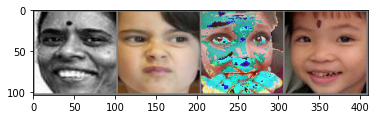

['happiness', 'disgust', 'fear', 'happiness']


In [42]:
# === Code adapted from Lab_08 of INM460 Computer Vision Module === ##

classes = {0: 'surprise', 1: 'fear', 2: 'disgust', 3: 'happiness', 4: 'sadness', 5: 'anger', 6: 'neutral'}

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize: back to range [0, 1] just for showing the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))     # Reshape: C, H, W -> H, W, C
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images and print labels
imshow(torchvision.utils.make_grid(images))
first_labels = [label.numpy().tolist() for label in labels]
label_classes = [classes[label] for label in first_labels if label in classes]
print(f'{label_classes}')

### Model Architechture

For CNN we will replicate an architecture similar to [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) [LeCun et al. 98]:

In [43]:
# === Code adapted from Lab_08 of INM460 === ##

class CNNmodel(nn.Module):

    def __init__(self):
        super(CNNmodel, self).__init__()
        # 3 input image channel, rgb image tensor
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.drop1=nn.Dropout(p=0.4)  # 1st dropout layer
        self.fc1 = nn.Linear(32 * 22 * 22, 120)  # 22*22 from image dimension
        self.drop2=nn.Dropout(p=0.2) # 2nd dropout layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.drop1(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [44]:
CNN = CNNmodel()
print(CNN)

CNNmodel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (drop1): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=15488, out_features=120, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)


In [45]:
# code adapted from https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model#:~:text=To%20get%20the%20parameter%20count,name%20and%20the%20parameter%20itself.

from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    return print(f"{type(model).__name__} with RGB images as input has {total_params} total trainable parameters")
    
count_parameters(CNN)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    1200    |
|  conv1.bias  |     16     |
| conv2.weight |   12800    |
|  conv2.bias  |     32     |
|  fc1.weight  |  1858560   |
|   fc1.bias   |    120     |
|  fc2.weight  |   10080    |
|   fc2.bias   |     84     |
|  fc3.weight  |    588     |
|   fc3.bias   |     7      |
+--------------+------------+
CNNmodel with RGB images as input has 1883487 total trainable parameters


In [46]:
# === Code adapted from Lab_08 of INM460 === ##
params = list(CNN.parameters())
print('Number of elements in params =', len(params))
print('conv1\'s weights size =', params[0].size())
print('conv1\'s biases size =', params[1].size())
print('conv2\'s weights size =', params[2].size())

Number of elements in params = 10
conv1's weights size = torch.Size([16, 3, 5, 5])
conv1's biases size = torch.Size([16])
conv2's weights size = torch.Size([32, 16, 5, 5])


### Skorch

In [47]:
checkpoint = Checkpoint(f_params='best_model.pt', monitor='valid_loss_best')
lr_scheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.1)
epochscoring = EpochScoring(scoring='accuracy', name='train_acc', on_train=True, lower_is_better=False)
early_stopping = EarlyStopping(monitor='valid_loss', patience = 3, threshold = 0.01, threshold_mode='rel', lower_is_better=True)

CNNnet = NeuralNetClassifier(
    CNN, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=4,
    max_epochs=30,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    train_split=predefined_split(val_dataset),
    callbacks=[lr_scheduler, checkpoint, epochscoring, early_stopping],
    device=device 
)

In [47]:
CNNnet.fit(train_dataset, y=y_train_);

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  -----------  ------------  -----------  ------------  ----  ------  -------
      1       0.4294        1.4759       0.6168        1.0401     +  0.0010  39.5451
      2       0.6472        0.9675       0.7289        0.7589     +  0.0010  40.5554
      3       0.7385        0.7285       0.7687        0.6538     +  0.0010  39.9052
      4       0.7935        0.5718       0.7937        0.5835     +  0.0010  40.7542
      5       0.8315        0.4725       0.7939        0.5772     +  0.0010  40.0680
      6       0.8594        0.4025       0.8268        0.4937     +  0.0010  40.7185
      7       0.8789        0.3506       0.8259        0.5493        0.0010  39.7378
      8       0.9274        0.2078       0.8612        0.4277     +  0.0001  40.5192
      9       0.9432        0.1633       0.8639        0.4280        0.0001  39.7741
     10       0.9498        0.1469       0.8647        0.4276    

### Evaluation

In [48]:
y_pred = CNNnet.predict(test_dataset)
accuracy_score(y_test_, y_pred)

0.7672750977835724

In [50]:
from sklearn import metrics
print(f"""Classification report for CNN:
      {metrics.classification_report(y_test_, y_pred)}\n""")

Classification report for CNN:
                    precision    recall  f1-score   support

           0       0.78      0.77      0.77       329
           1       0.60      0.46      0.52        74
           2       0.45      0.36      0.40       160
           3       0.89      0.90      0.89      1185
           4       0.70      0.67      0.68       478
           5       0.69      0.64      0.66       162
           6       0.69      0.77      0.73       680

    accuracy                           0.77      3068
   macro avg       0.68      0.65      0.67      3068
weighted avg       0.76      0.77      0.76      3068




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


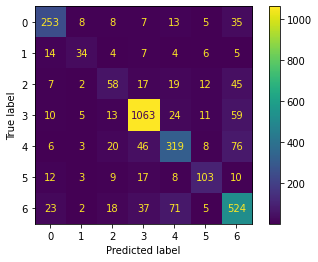

In [51]:
plot_confusion_matrix(CNNnet,test_dataset, y_test_.reshape(-1, 1))
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


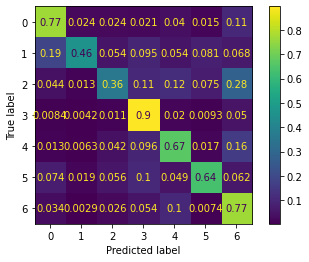

In [65]:
plot_confusion_matrix(CNNnet,test_dataset, y_test_.reshape(-1, 1), normalize='true')
plt.show()

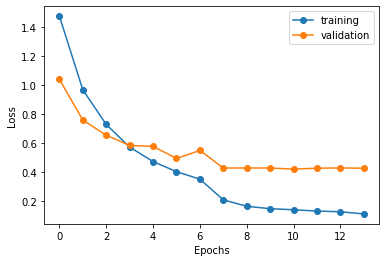

In [67]:
train_loss = CNNnet.history[:, 'train_loss']
valid_loss = CNNnet.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

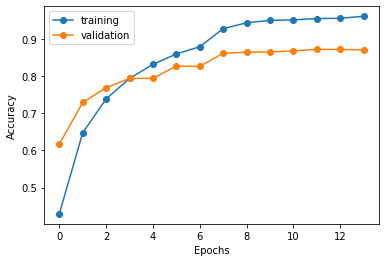

In [68]:
train_acc = CNNnet.history[:, 'train_acc']
valid_acc = CNNnet.history[:, 'valid_acc']

plt.plot(train_acc, 'o-', label='training')
plt.plot(valid_acc, 'o-', label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [54]:
# params = {
#     'lr': [0.001, 0.0001],
#     'optimizer__momentum': [0.8, 0.9],
#     'batch_size': [4, 8, 16],
#     # 'net__optimizer': [optim.Adam, optim.SGD]
# }

# gs = GridSearchCV(net, params, refit=False, cv=2, scoring='f1', verbose=2, return_train_score=True, error_score='raise')
# gs.fit(train_dataset, y=y_train_);

In [55]:
CNNnet.save_params(f_params='CNNnet.pkl')

In [59]:
!cp CNNnet.pkl /content/drive/MyDrive/CW_Folder_PG/Models/

In [64]:
!cp CNNnet.pkl /content/drive/MyDrive/CW_Folder_PG/Video/ 

In [62]:
# !cp best_model.pt /content/drive/MyDrive/CW_Folder_PG/Video